## Insight 3 

Penalized logistic regression with bigrams is the best OLS model. However, with a low AUC score of 54, we must consider exploring random forest or decision tree models to achieve greater accuracy predicting monetary relief. Furthermore, only a minority (32.7%) of complaints have narratives, making NLP an insufficient tool to apply to total dataset. We must consider an unsupervised model to sufficientlky address text and otehr data to predict monetray relief outcomes. 

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, f1_score, classification_report

from sklearn.preprocessing import LabelEncoder



# Silence the Warnings :)
import warnings
warnings.filterwarnings('ignore') 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [31]:
import re

import spacy
#! python -m spacy download en_core_web_sm
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
stopword_list.append('XXXX')
stopword_list.append('XXX')
stopword_list.append('XX')

In [32]:
# Import the data

data = pd.read_csv('complaints.csv')

In [116]:
data.shape

(1489331, 18)

In [73]:
# Subset only data that includes consumer complaint narratives

df_narr = data[(data['Consumer complaint narrative'].isnull()==False)]
df_narr.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
2,2019-10-25,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I would like to request the suppression of the...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,937XX,NaN,Consent provided,Web,2019-10-25,Closed with explanation,Yes,NaN,3417821
3,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
10,2019-09-08,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Fraud or scam,NaN,"I was sold access to an event digitally, of wh...",NaN,"Paypal Holdings, Inc",RI,029XX,NaN,Consent provided,Web,2019-09-08,Closed with explanation,Yes,NaN,3366475
11,2019-09-24,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,While checking my credit report I noticed thre...,Company has responded to the consumer and the ...,"HCFS Health Care Financial Services, Inc.",FL,333XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3385399


In [74]:
df_narr.shape

(487582, 18)

In [75]:
# Create a new column called df_narr.monetary where the value is 1
# if df_narr['Company response to consumer'] is 'Closed with monetary relief' and 0 if not

df_narr['monetary'] = np.where(df_narr['Company response to consumer']=='Closed with monetary relief', 1, 0)
df_narr.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,monetary
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392,0
2,2019-10-25,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I would like to request the suppression of the...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,937XX,NaN,Consent provided,Web,2019-10-25,Closed with explanation,Yes,NaN,3417821,0
3,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198,0
10,2019-09-08,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Fraud or scam,NaN,"I was sold access to an event digitally, of wh...",NaN,"Paypal Holdings, Inc",RI,029XX,NaN,Consent provided,Web,2019-09-08,Closed with explanation,Yes,NaN,3366475,0
11,2019-09-24,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,While checking my credit report I noticed thre...,Company has responded to the consumer and the ...,"HCFS Health Care Financial Services, Inc.",FL,333XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3385399,0


In [76]:
df_narr.shape

(487582, 19)

In [77]:
# Sample n = 25k entries in order to reduce computer processing time

df_narr_25k = df_narr.sample(n=25001, random_state=42)
df_narr_25k.shape

(25001, 19)

In [78]:
df_narr_25k.iloc[123,5]

'A payment I sent into Barclays Bank for my credit card for XXXX was miscoded by XXXX. They took XXXX. This resulted in my checking account being over drafted and fees of {$220.00}.'

In [79]:
# Data Cleaning

# Remove Special Characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

i = 0
cell = df_narr_25k.iloc[0,5]

while i < 25000:
    df_narr_25k.iloc[i,5] = remove_special_characters(cell)
    i += 1
    cell = df_narr_25k.iloc[i,5]

In [82]:
df_narr_25k.tail()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,monetary
383986,2017-10-01,Credit card or prepaid card,General-purpose credit card or charge card,Problem when making payments,You never received your bill or did not know a...,I was shocked when reviewing my credit report ...,NaN,CAPITAL ONE FINANCIAL CORPORATION,CA,920XX,NaN,Consent provided,Web,2017-10-01,Closed with explanation,Yes,NaN,2689736,0
71802,2019-05-08,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,As a Missourian in concert with the state law ...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MO,NaN,NaN,Consent provided,Web,2019-05-08,Closed with explanation,Yes,NaN,3235675,0
1280501,2018-02-06,"Credit reporting, credit repair services, or o...",Credit repair services,Confusing or misleading advertising or marketing,NaN,I AM A XXXX XXXX XXXX VETERAN AND MY CREDIT RE...,NaN,"Performance Settlement, LLC",CA,92393,Servicemember,Consent provided,Web,2018-02-06,Closed with explanation,No,NaN,2805977,0
910453,2016-06-30,Debt collection,Credit card,Cont'd attempts collect debt not owed,Debt was paid,BLEIER COX APC is misrepresenting and falsely...,NaN,Bleier & Cox APC,CA,917XX,NaN,Consent provided,Web,2016-06-30,Closed with explanation,Yes,No,1992760,0
84231,2019-05-23,"Money transfer, virtual currency, or money ser...",International money transfer,Other transaction problem,NaN,"On XX/XX/2019, I transferred {$780.00} to my d...",NaN,"Paypal Holdings, Inc",WY,820XX,NaN,Consent provided,Web,2019-05-23,Closed with monetary relief,Yes,NaN,3252059,1


In [85]:
# Drop last row which was not processed by Remove Special Characters function

#(df.drop(index='Charlie')
df_narr_25k = df_narr_25k.drop(df_narr_25k.index[-1])
df_narr_25k.shape

(25000, 19)

In [86]:
df_narr_25k.tail()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,monetary
1310413,2018-04-04,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Add-on products and services,I filed an return protection claim for an exte...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",DC,200XX,NaN,Consent provided,Web,2018-04-04,Closed with non-monetary relief,Yes,NaN,2864161,0
383986,2017-10-01,Credit card or prepaid card,General-purpose credit card or charge card,Problem when making payments,You never received your bill or did not know a...,I was shocked when reviewing my credit report ...,NaN,CAPITAL ONE FINANCIAL CORPORATION,CA,920XX,NaN,Consent provided,Web,2017-10-01,Closed with explanation,Yes,NaN,2689736,0
71802,2019-05-08,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,As a Missourian in concert with the state law ...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MO,NaN,NaN,Consent provided,Web,2019-05-08,Closed with explanation,Yes,NaN,3235675,0
1280501,2018-02-06,"Credit reporting, credit repair services, or o...",Credit repair services,Confusing or misleading advertising or marketing,NaN,I AM A XXXX XXXX XXXX VETERAN AND MY CREDIT RE...,NaN,"Performance Settlement, LLC",CA,92393,Servicemember,Consent provided,Web,2018-02-06,Closed with explanation,No,NaN,2805977,0
910453,2016-06-30,Debt collection,Credit card,Cont'd attempts collect debt not owed,Debt was paid,BLEIER COX APC is misrepresenting and falsely...,NaN,Bleier & Cox APC,CA,917XX,NaN,Consent provided,Web,2016-06-30,Closed with explanation,Yes,No,1992760,0


In [87]:
df_narr_25k.iloc[123,5]

'A payment I sent into Barclays Bank for my credit card for XXXX was miscoded by XXXX They took XXXX This resulted in my checking account being over drafted and fees of 22000'

Class 0: 23657
Class 1: 1343
Proportion: 17.62


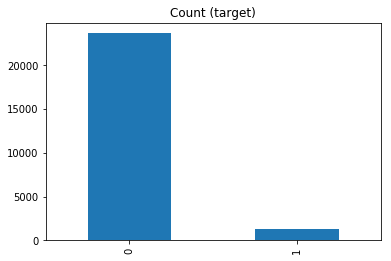

In [88]:
# Explore y data

# Assign complaint data to an object
target = df_narr_25k.monetary[0:25000]

target_count = target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2))

target_count.plot(kind='bar', title='Count (target)');

In [89]:
# Explore X data

# Assign text data to an object
complaint = df_narr_25k['Consumer complaint narrative']

# Examine the data
print("Length of Text: {} characters".format(len(complaint)))
print ("")

# Here I pick a random line from the complaints to print. I just want to see what it looks like.
print("Text Sample:\n{}".format(complaint[13]))

Length of Text: 25000 characters

Text Sample:
MY NAME IS XXXX XXXX XXXX I live at XXXX XXXX XXXX XXXX XXXX SC XXXX My DOB XXXX my SS XXXX I have addresses on my file that are not mine please remove the following addresses  XXXX XXXX XXXX XXXX XXXX XXXX XXXX OH XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX OH XXXX XXXX XXXX XXXX XXXX XXXX XXXX OH XXXX XXXX XXXX XXXX XXXX XXXX XXXX NY XXXX XXXX XXXX XXXX XXXX OH XXXX XXXX XXXX XXXX XXXX OH XXXX XXXX XXXX XXXX XXXX OH XXXX XXXX XXXX XXXX  XXXX OH XXXX XXXX XXXX XXXX XXXX XXXX XXXX OH XXXX XXXX XXXX  XXXX XXXX XXXX XXXX XXXX NJ XXXX 
I have attach my proof of ID and address


In [90]:
# Vectorize the Complaint Narrative column into an X matrix

# Vectorize
count = CountVectorizer().fit(complaint)

In [91]:
# Look at the CountVector... 
print(count.vocabulary_)

{'had': 15393, 'student': 30492, 'loan': 19252, 'with': 34770, 'the': 31525, 'department': 10392, 'of': 22224, 'education': 12003, 'that': 31502, 'been': 5379, 'sold': 29611, 'or': 22669, 'handled': 15461, 'by': 6373, 'company': 8076, 'xxxx': 35214, 'have': 15630, 'paid': 23131, 'my': 21105, 'as': 4339, 'directed': 10869, 'to': 32049, 'now': 21940, 'credit': 9304, 'report': 26964, 'shows': 29127, 'for': 14205, 'and': 3728, 'being': 5445, 'in': 16758, 'default': 10080, 'when': 34565, 'called': 6470, 'dept': 10472, 'they': 31689, 'claim': 7466, 'no': 21576, 'account': 2489, 'them': 31581, 'anymore': 3906, 'handle': 15460, 'this': 31749, 'situation': 29350, 'through': 31847, 'reporting': 27003, 'agency': 3190, 'former': 14365, 'mortgage': 20870, 'was': 34326, 'bought': 5978, 'out': 22817, 'green': 15244, 'tree': 32504, 'statements': 30134, 'from': 14611, 'are': 4207, 'about': 2310, '30000': 1031, 'more': 20837, 'month': 20783, 'fixed': 13989, 'rate': 25669, 'nothing': 21863, 'else': 12157

In [92]:
# Transform text into numbers
X = count.transform(complaint)

In [93]:
# What does the new transformed data look like?

print('New Vector X:\n{}'.format(repr(X)))

New Vector X:
<25000x36140 sparse matrix of type '<class 'numpy.int64'>'
	with 2232184 stored elements in Compressed Sparse Row format>


In [94]:
# Clean the data

###### These are 'stop-words'
####from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
####print("Number of stop words: {}".format(len(ENGLISH_STOP_WORDS)))
####print("Every 10th stopword:\n{}".format(list(ENGLISH_STOP_WORDS)[::10]))

In [95]:
# Here, I...  
##  Limit vocabulary to meaningful words by deleting Stop-words
##  Remove terms that appear too frequently, max_df
##  Remove terms that appear too infrequently, min_df

# Vectorize (again)
#### count = CountVectorizer(stop_words="english", min_df = 5, max_df = 5).fit(complaint)
count = CountVectorizer(stop_words=stopword_list, min_df = 5, max_df = 5).fit(complaint)
X = count.transform(complaint)
print("Vectorized X:\n{}".format(repr(X)))

Vectorized X:
<25000x826 sparse matrix of type '<class 'numpy.int64'>'
	with 4130 stored elements in Compressed Sparse Row format>


In [96]:
# Here's what the data looks like now
feature_names = count.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 10 features:\n{}".format(feature_names[:10]))
print("Features 100 to 110:\n{}".format(feature_names[100:110]))
print("Features 500 to 510:\n{}".format(feature_names[400:410]))
print("Every 200th feature:\n{}".format(feature_names[::200]))

Number of features: 826
First 10 features:
['102', '1036', '1199', '160', '1681s', '1934', '1935', '1990', '210', '240']
Features 100 to 110:
['bee', 'bench', 'benefiting', 'benz', 'berate', 'bestbuy', 'bids', 'bilateral', 'billion', 'biz']
Features 500 to 510:
['insurers', 'intact', 'intense', 'interact', 'intercede', 'intermediary', 'intolerable', 'introduce', 'intrusion', 'inventory']
Every 200th feature:
['102', 'credi', 'insurers', 'reexplain', 'wrap']


In [97]:
# Stemming

# Instantiate nltk's Porter stemmer
stemmer = nltk.stem.PorterStemmer()

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    
# Define a count vectorizer with the custom tokenizer
####lemma_vect = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words="english", min_df = 5, max_df = 5)
lemma_vect = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words=stopword_list, min_df = 5, max_df = 5)

# Examine the data
print(lemma_vect.fit(complaint).get_feature_names())

['102', '1036', '1199', '160', '1681s', '1934', '1935', '1990', '210', '240', '2605', '2699', '2weeks', '2years', '30th', '337', '392', '3day', '41000000', '44', '4600000', '48000000', '5100000', '524', '5400000', '5700000', '5900000', '6300000', '6400000', '704', '7100000', '714', '7400000', '775', '7800000', '825', '880000', '8900000', '92', '9200000', '``', 'a1', 'absolved', 'absorb', 'abut', 'abysmal', 'accelerator', 'accidently', 'acco', 'accountlevel', 'accreditation', 'achieving', 'acronym', 'addressi', 'addtional', 'adjacent', 'adv', 'adviced', 'afloat', 'aggravating', 'agony', 'agreeable', 'ai', 'airfare', 'aligns', 'alimony', 'allowance', 'alongside', 'annoy', 'annum', 'appreciates', 'aprox', 'argues', 'argumentative', 'array', 'artificial', 'asleep', 'assetbacked', 'astoria', 'attache', 'attacking', 'attain', 'attested', 'aud', 'auth', 'autodraft', 'automation', 'averaging', 'averment', 'awesome', 'b4', 'backdate', 'ballon', 'banana', 'banki', 'banksand', 'baring', 'barley',

In [98]:
# Transform complaint narratives using CountVectorizer with lemmatization
X_lemma = lemma_vect.fit_transform(complaint)

# Examine the data
print("X_lemma: {}".format(repr(X_lemma)))

X_lemma: <25000x762 sparse matrix of type '<class 'numpy.int64'>'
	with 3810 stored elements in Compressed Sparse Row format>


In [99]:
# Rescale the data with tf-idf

# Define a tfid vectorizer with the custom tokenizer
####vect = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words="english", min_df = 5, max_df = 5).fit(complaint)
vect = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words=stopword_list, min_df = 5, max_df = 5).fit(complaint)

# Transform reviews using TfidfVectorizer with lemmatization
X = vect.transform(complaint)

# Examine the data
print("X: {}".format(repr(X)))

X: <25000x762 sparse matrix of type '<class 'numpy.float64'>'
	with 3810 stored elements in Compressed Sparse Row format>


In [100]:
# Create X, y variables
X = X
y = df_narr_25k.monetary

In [101]:
# Inspect all models by visualizing the coefficient

# Function for Visualizing Coefficients in Each Model
def visualize_coefficients(coefficients, feature_names, n_top_features=25):

    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ['#ff2020' if c < 0 else '#0000aa'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Features")

In [102]:
# Run at least 3 models and select a single best model

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [103]:
# Model 1: Logistic regression weighted with tf-idf

# Test for Best Model Parameters of the Weighted Logistic Regression Model with GridSearch & Cross Validation 
# using a metric appropriate for imbalanced classification (AUC), scoring = 'roc_auc'

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=cv, scoring='roc_auc').fit(X_train, y_train)
grid_1 = grid.best_score_

print("WEIGHTED LOGISTIC REGRESSION")
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

WEIGHTED LOGISTIC REGRESSION
Best cross-validation score: 0.50
Best parameters:  {'C': 10}


MODEL 1: WEIGHTED LOGISTIC REGRESSION
AUC Score: 0.50

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5905
           1       0.15      0.01      0.01       345

    accuracy                           0.94      6250
   macro avg       0.55      0.50      0.49      6250
weighted avg       0.90      0.94      0.92      6250



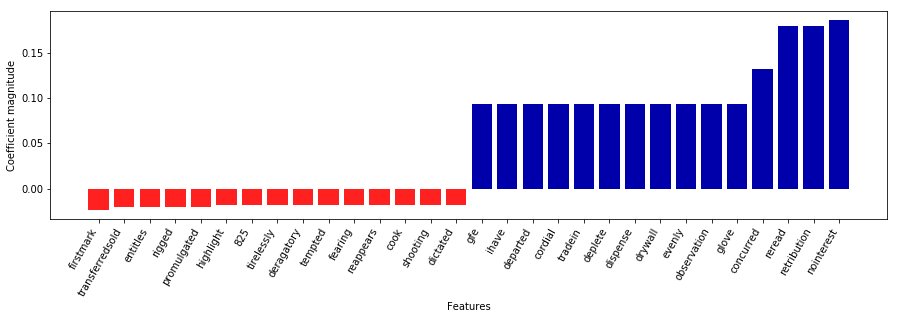

In [104]:
# Visualize Coefficients for Logistic Regression Model with Best Parameters
coefs = LogisticRegression(C=.1).fit(X_test,y_test).coef_
feature_names = vect.get_feature_names()
visualize_coefficients(coefs, feature_names, n_top_features=15)

# Evaluate Model Using AUC
y_predict = grid.predict(X_test)
auc_1 = roc_auc_score(y_test, y_predict)

# Evaluate Model Using Test Data 
grid.fit(X_test, y_test)

print("MODEL 1: WEIGHTED LOGISTIC REGRESSION")

# AUC Score: Probability that the model ranks a random positive example more highly than a random negative example
print("AUC Score: {:.2f}".format(auc_1))
print("")

print(classification_report(y_test, y_predict))

In [107]:
# Model 2: Penalized logistic regression weighted with tf-idf

# Test for Best Model Parameters of the Logistic Regression Model with GridSearch & Cross Validation
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(penalty='l1'), param_grid, cv=cv, scoring='roc_auc').fit(X_train, y_train)
grid_2 = grid.best_score_

print("WEIGHTED PENALIZED LOGISTIC REGRESSION")
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

WEIGHTED PENALIZED LOGISTIC REGRESSION
Best cross-validation score: 0.50
Best parameters:  {'C': 1}


MODEL 2: WEIGHTED PENALIZED LOGISTIC REGRESSION
AUC Score: 0.50

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5905
           1       0.00      0.00      0.00       345

    accuracy                           0.94      6250
   macro avg       0.47      0.50      0.49      6250
weighted avg       0.89      0.94      0.92      6250



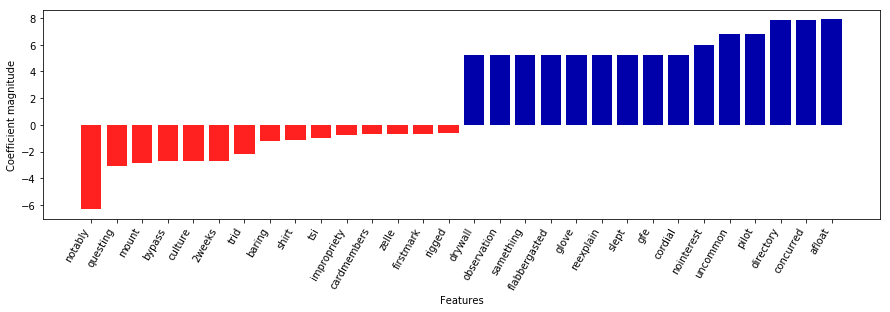

In [108]:
# Visualize Coefficients for Weighted Penalized Logistic Regression
coefs = LogisticRegression(penalty='l1', C=10).fit(X_test,y_test).coef_
feature_names = vect.get_feature_names()
visualize_coefficients(coefs, feature_names, n_top_features=15)

# Evaluate Model Using AUC
y_predict = grid.predict(X_test)
auc_2 = roc_auc_score(y_test, y_predict)

# Evaluating Model Using Test Data 
grid.fit(X_test, y_test)

print("MODEL 2: WEIGHTED PENALIZED LOGISTIC REGRESSION")

# AUC Score
print("AUC Score: {:.2f}".format(auc_2))
print("")

print(classification_report(y_test, y_predict))

In [109]:
# Model 2: Penalized logistic regression with Bigrams weighted with tf-idf

# Build the Bigram Model
####bigrams_vect = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words="english", ngram_range=(2, 2), min_df = 5, max_df = 5).fit(complaint)
bigrams_vect = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words=stopword_list, ngram_range=(2, 2), min_df = 5, max_df = 5).fit(complaint)

In [110]:
# Transform data!
X = bigrams_vect.transform(complaint)

# Examine the data
print("X: {}".format(repr(X)))

X: <25000x12704 sparse matrix of type '<class 'numpy.float64'>'
	with 63520 stored elements in Compressed Sparse Row format>


In [111]:
# Split data
X = X
y = df_narr_25k.monetary

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [112]:
# Test for Best Model Parameters of  Logistic Regression Model with GridSearch & Cross Validation
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(penalty='l1'), param_grid, cv=cv, scoring='roc_auc').fit(X_train, y_train)
grid_3 = grid.best_score_

print("WEIGHTED PENALIZED LOGISTIC REGRESSION with BIGRAMS")
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

WEIGHTED PENALIZED LOGISTIC REGRESSION with BIGRAMS
Best cross-validation score: 0.60
Best parameters:  {'C': 10}


MODEL 2: WEIGHTED PENALIZED LOGISTIC REGRESSION with BIGRAMS
AUC Score: 0.54

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      5905
           1       0.20      0.11      0.14       345

    accuracy                           0.93      6250
   macro avg       0.58      0.54      0.55      6250
weighted avg       0.91      0.93      0.92      6250



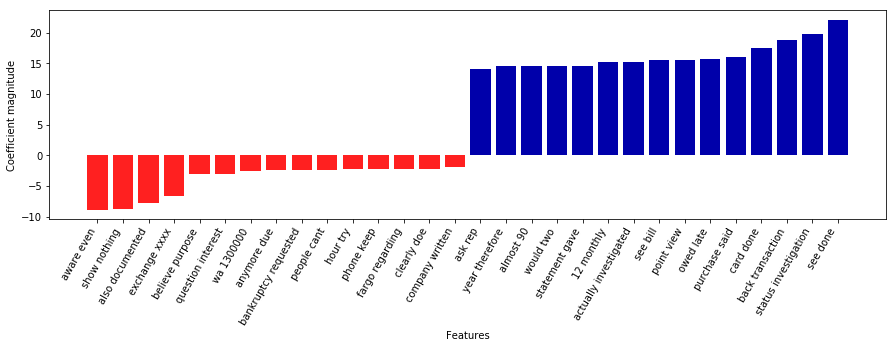

In [113]:
# Visualize Coefficients for Weighted Penalized Logistic Regression
coefs = LogisticRegression(penalty='l1', C=10).fit(X_test,y_test).coef_
feature_names = bigrams_vect.get_feature_names()  # Notice, here that I'm using bigrams_vect to get features names
visualize_coefficients(coefs, feature_names, n_top_features=15)

# Evaluate Model Using AUC
y_predict = grid.predict(X_test)
auc_3 = roc_auc_score(y_test, y_predict)

# Evaluating Model Using Test Data 
grid.fit(X_test, y_test)

print("MODEL 2: WEIGHTED PENALIZED LOGISTIC REGRESSION with BIGRAMS")

# AUC Score
print("AUC Score: {:.2f}".format(auc_3))
print("")

print(classification_report(y_test, y_predict))

In [114]:
# Summary of Training Results
print("SUMMARY OF AUC SCORES from TRAINING")
print("Logistic Regression: {:.2f}".format(grid_1))
print("Penalized Logistic Regression: {:.2f}".format(grid_2))
print("Penalized Logistic Regression with Bigrams: {:.2f}".format(grid_3))

SUMMARY OF AUC SCORES from TRAINING
Logistic Regression: 0.50
Penalized Logistic Regression: 0.50
Penalized Logistic Regression with Bigrams: 0.60


In [115]:
# Summary of Test Results
print("SUMMARY OF AUC SCORES")
print("Logistic Regression: {:.2f}".format(auc_1))
print("Penalized Logistic Regression: {:.2f}".format(auc_2))
print("Penalized Logistic Regression with Bigrams: {:.2f}".format(auc_3))

SUMMARY OF AUC SCORES
Logistic Regression: 0.50
Penalized Logistic Regression: 0.50
Penalized Logistic Regression with Bigrams: 0.54
